In [1]:
import warnings
warnings.filterwarnings("ignore") # This is very bad practice but fuck it I don't care I'm too tired

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
housing = pd.read_csv('data/train.csv').drop(columns=['Id'])
for col in housing:
    num_nans = housing[col].isnull().sum() / housing.shape[0]
    if num_nans > 0.8: # Drop any columns with more than 80% nans
        print('Dropping column', col, 'which has' , num_nans, 'nans')
        housing = housing.drop(columns=[col])

y = housing[['SalePrice']]
x = housing.drop(columns=['SalePrice'])
print(len(x.columns))
print(x.head())
print(y.head())

Dropping column Alley which has 0.9376712328767123 nans
Dropping column PoolQC which has 0.9952054794520548 nans
Dropping column Fence which has 0.8075342465753425 nans
Dropping column MiscFeature which has 0.963013698630137 nans
75
   MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0    AllPub    Inside       Gtl  ...          61             0         0   
1    AllPub       FR2       Gtl  ...           0             0         0   
2    AllPub    Inside       Gtl  ...          42             0         0   
3    A

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

def preprocess(x, y):
    x_preprocessed = x.copy()
    y_preprocessed = y.copy()
    numeric_cols = x_preprocessed.select_dtypes(include=np.number).columns.tolist()
    categoric_cols = x_preprocessed.select_dtypes(include='object').columns.tolist()

    if len(numeric_cols) > 0:
        mean_imputer = SimpleImputer()
        mean_imputer.fit(x_preprocessed[numeric_cols])
        x_preprocessed[numeric_cols] = mean_imputer.transform(x_preprocessed[numeric_cols])

        scaler = StandardScaler()
        scaler.fit(x_preprocessed[numeric_cols])
        x_preprocessed[numeric_cols] = scaler.transform(x_preprocessed[numeric_cols])

    if len(categoric_cols) > 0:
        mode_imputer = SimpleImputer(strategy='most_frequent')
        mode_imputer.fit(x_preprocessed[categoric_cols])
        x_preprocessed[categoric_cols] = mode_imputer.transform(x_preprocessed[categoric_cols])

        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoder.fit(x_preprocessed[categoric_cols])
        encoded_cols = list(encoder.get_feature_names_out())
        x_preprocessed[encoded_cols] = encoder.transform(x_preprocessed[categoric_cols])
        x_preprocessed = x_preprocessed.drop(columns=categoric_cols)

    return x_preprocessed, y_preprocessed

In [4]:
from sklearn.model_selection import train_test_split

x_preprocessed, y_preprocessed = preprocess(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, y_preprocessed, test_size=0.2, random_state=12)

In [5]:
# Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

def ridge_regression(alpha, x_train, y_train, x_test, y_test):
    model = Ridge(alpha=alpha).fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)

    train_rmse = np.sqrt(np.mean((train_preds - y_train)**2))
    test_rmse = np.sqrt(np.mean((test_preds - y_test)**2))

    return train_rmse, test_rmse

In [6]:
train_rmse, test_rmse = ridge_regression(0.0, x_train, y_train, x_test, y_test)
print("Vanilla Regression Training Set RMSE:", train_rmse)
print("Vanilla Regression Test Set RMSE:", test_rmse)

Vanilla Regression Training Set RMSE: SalePrice    20510.568235
dtype: float64
Vanilla Regression Test Set RMSE: SalePrice    8.573311e+17
dtype: float64


Text(0.5, 0, 'log2(lambda)')

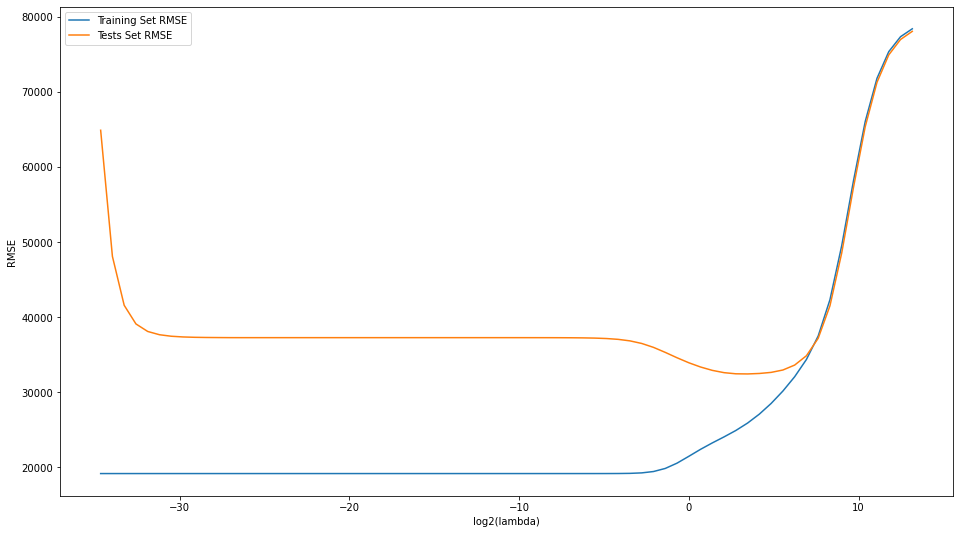

In [7]:
alpha = np.array([2 ** i for i in range(-50, 20)])
results = np.array([ridge_regression(a, x_train, y_train, x_test, y_test) for a in alpha])

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(np.log(alpha), results[:, 0], label='Training Set RMSE')
ax.plot(np.log(alpha), results[:, 1], label='Tests Set RMSE')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_xlabel('log2(lambda)')

<AxesSubplot:xlabel='SalePrice'>

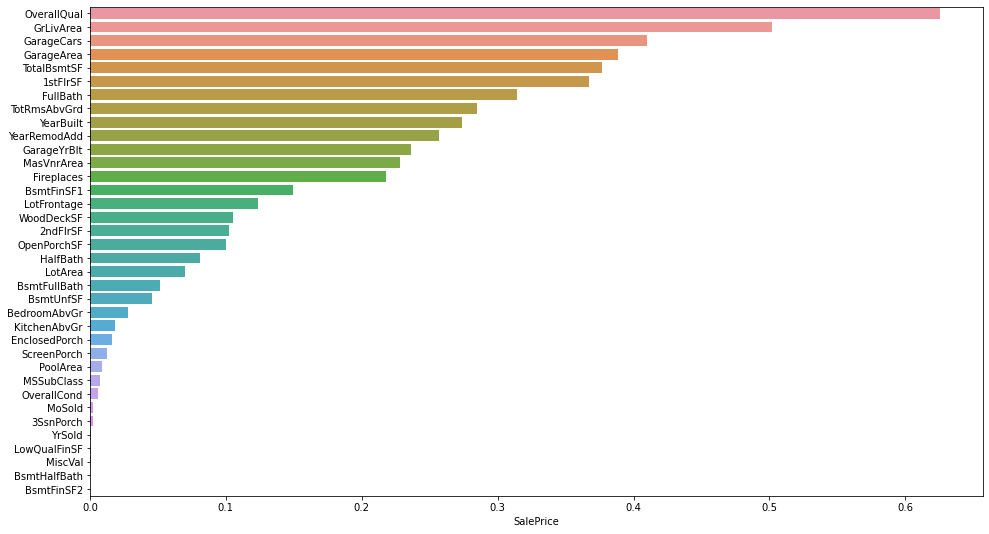

In [8]:
corr = (housing.corr()['SalePrice'] ** 2).sort_values(ascending=False)[1:]
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=corr,y=corr.index)

 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 95/274 [00:01<00:02, 74.39it/s]


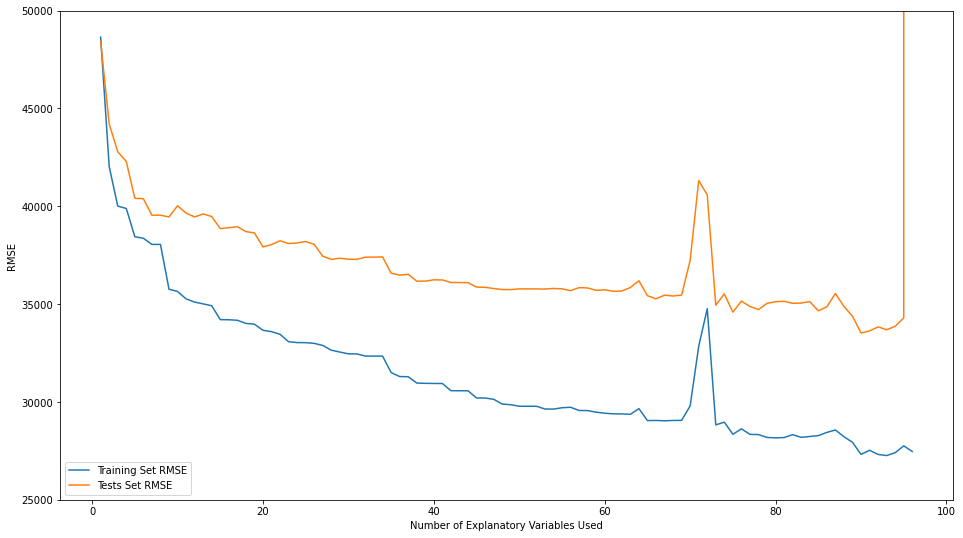

In [9]:
results = []
corr = (pd.concat([x_preprocessed, y_preprocessed], axis=1).corr()['SalePrice'] ** 2).sort_values(ascending=False)[1:]
#corr = corr[corr > 0.05]
for i in tqdm(range(1, len(corr))):
    x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, y_preprocessed, test_size=0.2, random_state=12)
    x_train = x_train[corr.index[:i]]
    x_test = x_test[corr.index[:i]]
    results += [ridge_regression(0, x_train, y_train, x_test, y_test)]
    if (results[-1][1] > 100000).any():
        break

results = np.array(results)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(np.arange(results.shape[0]) + 1, results[:, 0], label='Training Set RMSE')
ax.plot(np.arange(results.shape[0]) + 1, results[:, 1], label='Tests Set RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('Number of Explanatory Variables Used')
ax.set_ylim(25000, 50000)
ax.legend()
